---
jupyter: python3
---

# Decision Theory in Classification

Machine learning algorithms are often used to make recommendations to inform decisions:

- Should a patient receive additional confirmatory screening for a rare disease?
- Should an email be sent to the spam folder, or should it be sent to the primary inbox?
- Should a prospective borrower be granted a loan?

An important feature of each of these examples is that there may be *asymmetric costs of error*. In many cases, it's worse to be wrong in one way than it is to be wrong in another. A patient who in fact *has* a rare disease but *is not* screened for it is at grave risk, while a patient who *does not* have a rare disease but *is* screened for it might only risk a higher bill. A frivolous email sent to the main inbox is an irritation, while an important email sent to the spam folder is an opportunity for consequential miscommunication. A prospective borrower who *is* granted a loan but *should not* have been granted a loan may default and lose money for the lender, while a prospective borrower who *is not* granted a loan but *should* have been granted a loan cannot default and therefore cannot incur losses for the lender.

In cases with asymmetric costs of error, selecting models based on *accuracy* may not be the right approach, since accuracy treats all types of error as equally weighty. In this set of notes, we'll go beyond accuracy and learn how to tune models for decision-making in the presence of asymmetric error costs.

We are going to *operationalize* this via the choice of the threshold $t$ in the score-based classification framework that we discussed [last time](03-score-based-classification.qmd). Let's do a quick recap:

## Last time...

...we considered a prediction problem in which we observed $p$ attributes of prospective borrower $i$ in the form of a vector $\mathbf{x}_i \in \mathbb{R}^p$. We then formed a *score* for prospective borrower $i$ using a weight vector $\mathbf{w}\in \mathbb{R}^p$ and an inner product:

[We also developed the ability to compute nonlinear scores by instead computing the score as $s_i = \langle \mathbf{w},\phi(\mathbf{x}_i) \rangle$, where $\phi$ was a **feature map** that computed nonlinear functions of the entries of $\mathbf{x}_i$. For reasons that we'll learn about when we study the theory of machine learning, this is *still* called a linear model, due to the fact that the score is a linear function of the vector $\mathbf{w}$. In this set of notes, we'll always assume that $\mathbf{x}$ has *already* had a feature map applied to it, so that we can just focus on the simpler form of @eq-linear-model.]{.aside}

$$
\begin{aligned}
    s_i = \langle \mathbf{x}_i, \mathbf{w}  \rangle\;.
\end{aligned}
$$ {#eq-linear-model}

Then, we *classified* prospective borrowers into two categories based on a threshold $t \in \mathbb{R}$:

- Borrowers who receive a loan had the property $s_i \leq t$.
- Borrowers who do not receive a loan have the property $s_i > t$.

@eq-linear-model says that the score should be computed as a *linear function* of the features $\mathbf{x}_i$. Models with this property are called *linear models* and are fundamental in both classification and regression tasks.

## Lending Data Set

To illustrate our discussion, we are going to pull up the lending data set from the previous section. [This hidden code cell imports several standard Python libraries and reads in our data, saving the result in a variable called `df`.]{.aside}

In [1]:
#| code-fold: true
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision = 3)
plt.style.use('seaborn-v0_8-whitegrid')

url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/credit_risk_dataset.csv"

df_all = pd.read_csv(url)
df = df_all[["loan_int_rate", "loan_percent_income", "loan_status"]]
df = df.dropna()

Following the usual paradigm in machine learning, we're going to incorporate two  elements which we previously saw [when studying the Palmer penguins](../source/02-black-box-classification.qmd). First, we are going to hold off a part of our data set that we will not use for making any choices about how we design our decision algorithm. This held-off part of the data is called the *test set*. We'll use it for a final evaluation of our model's performance.

In [5]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 123) # 20% test set

Next, we'll distinguish our predictor and target variables in each of the train and test sets.

In [6]:
X_train = df_train[["loan_int_rate", "loan_percent_income"]]
y_train = df_train["loan_status"]

X_test = df_test[["loan_int_rate", "loan_percent_income"]]
y_test = df_test["loan_status"]

Now we're ready to proceed in making predictions and comparing our predictions to outcomes in both the training and test sets.

## Vectorized Computation of Scores


Suppose that we have a weight vector $\mathbf{w}$ and that we'd like to choose a threshold $t$. To do this, we will compute all the scores on the training data and do some experiments. How should we compute training scores? As we know, the $i$th score is given by @eq-linear-model. To compute scores for all $n$ of our training points, we could write a loop like this: [In our case, $n =$ `{python} df_train.shape[0]`, the number of rows in the training data.]{.aside}

In [7]:
#| eval: false
n = df_train.shape[0]
s = [] # vector of scores
for i in range(n):
    s.append(compute_score(X[i], w))

NameError: name 'compute_score' is not defined

where `X[i]` is the `i`th data point $\mathbf{x}_i$ and  `compute_score` is a function that computes the score according to @eq-linear-model. However, there's a better way to do this if we step back from code into math for a moment. If $\mathbf{s} \in \mathbb{R}^n$ is a vector whose $i$th entry is the score $s_i$, then we have

$$
\begin{aligned}
    \mathbf{s} = \left(
        \begin{matrix}
            \langle \mathbf{x}_1, \mathbf{w} \rangle \\
            \langle \mathbf{x}_2, \mathbf{w} \rangle \\
            \vdots \\
            \langle \mathbf{x}_n, \mathbf{w} \rangle
        \end{matrix}
        \right) = \mathbf{X}\mathbf{w}\;,
\end{aligned}
$$

where we have defined the *predictor matrix* $\mathbf{X} \in \mathbb{R}^{n \times p}$

$$
\begin{aligned}
    \mathbf{X} = \left[
        \begin{matrix}
            \rule[.5ex]{2.5ex}{0.5pt} \; \mathbf{x}_1 \;\rule[.5ex]{2.5ex}{0.5pt}  \\
            \rule[.5ex]{2.5ex}{0.5pt}\;\mathbf{x}_2 \; \rule[.5ex]{2.5ex}{0.5pt}  \\
            \vdots \\
            \rule[.5ex]{2.5ex}{0.5pt} \;  \mathbf{x}_n \;\rule[.5ex]{2.5ex}{0.5pt}
        \end{matrix}
        \right] =
        \left[
        \begin{matrix}
            x_{11} & x_{12} & \cdots & x_{1p} \\
            x_{21} & x_{22} & \cdots & x_{2p} \\
            \vdots \\
            x_{n1} & x_{n2} & \cdots & x_{np}
        \end{matrix}
        \right]\;.
\end{aligned}
$$

This is good news because it simplifies our life both mathematically and in code: the Numpy package supplies very fast matrix multiplication:

In [8]:
def linear_score(X, w):
  return X@w # or np.dot(X, w)

Now, given $\mathbf{w}$, we can compute all the scores at once. To do this, we'll finally choose a value for $\mathbf{w}$: [Again, the topic of *how to choose $\mathbf{w}$ is the topic of *model training*, which we'll study in detail soon.]{.aside}

In [9]:
w= np.array([0.01, 1.0])
s= linear_score(X_train, w)

Importantly, we were able to compute all of our scores on the training data without writing any loops. This is both easier for us to read/write and much faster for most computers to execute; the reason is that Numpy is able to use highly optimized C code to perform the matrix multiplication.

Here is a histogram of the scores we just computed:

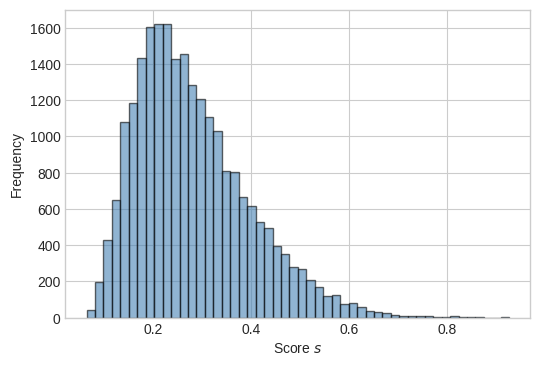

In [10]:
#| code-fold: true
#| fig-cap: Histogram of scores computed via @eq-linear-model.
#| label: fig-score-histogram

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
hist = ax.hist(s, bins = 50, color = "steelblue", alpha = 0.6, linewidth = 1, edgecolor = "black")
labs = ax.set(xlabel = r"Score $s$", ylabel = "Frequency")

We see that most of the scores are relatively small, but that a small number of scores are over $0.5$. Numpy offers many helpful vectorized operations which make it quick to answer simple questions about the data. For example, what proportion of scores are larger than $0.5$?

In [12]:
(s > 0.5).mean()

0.050398778211437296

## Types of Error

Once we have a vector of scores $\mathbf{s}$, we can create a vector of *predictions* simply by applying a threshold $t$. Here's our training predictions for the loan data using a threshold $t = 0.4$: [Recall that a prediction of `True` means that the individual is considered likely to default on their loan and therefore should *not* be offered credit.]{.aside}

In [14]:
t = 0.4
preds= 1*(s >= t)
preds.head()

,0
17279,0
14157,1
25427,0
23449,1
14739,1


What proportion of individuals are predicted to default?

In [15]:
preds.mean()

0.15386899711522145

Of course, this result depends strongly on our choice of threshold $t$. How should we choose it? One possibility would be to try to choose the threshold in a way that maximizes the training accuracy, the number of times that the prediction agrees with the actual outcome (repaid or default) on the training data. Here's an example of a quick grid search:

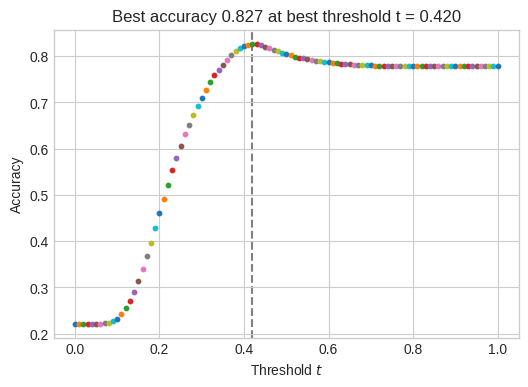

In [19]:
#| fig-cap: "Accuracy as a function of threshold in the credit default prediction problem."
#| label: fig-accuracy-threshold

best_accuracy = 0
best_threshold = 0

fig, ax= plt.subplots(1, 1, figsize = (6, 4))
for t in np.linspace(0, 1, 101): #gives 101 evenely sized spaces between 0 and 1
  y_pred = s >= t
  acc= (y_pred == y_train).mean()
  ax.scatter(t, acc, s= 10)
  if acc > best_accuracy:
    best_accuracy = acc
    best_threshold = t


ax.axvline(best_threshold, linestyle = "--", color = "grey", zorder = -10)
labs = ax.set(xlabel = r"Threshold $t$", ylabel = "Accuracy", title = f"Best accuracy {best_accuracy:.3f} at best threshold t = {best_threshold:.3f}")

However, accuracy is not always the most relevant measure. For example, [Field and Stream estimates](https://www.fieldandstream.com/survival/how-many-shark-attacks-per-year/#:~:text=In%20recent%20years%2C%20there's%20been,%E2%80%94a%2010%2Dyear%20low.) that there are, globally, approximately 70 unprovoked shark attacks each year. Since the population of the world is currently around $8.1\times 10^9$  people, the average probability that a specific individual will suffer an unprovoked shark attack in a year is approximately $70 / (8.1 \times 10^9) \approx 8.6 \times 10^{-9}$. So, if we created a shark attack predictor which always predicted "no shark attack," our model would be correct approximately 99.999999% of the time. However, this model wouldn't be very *useful*, and wouldn't have anything to tell us about the activities that increase or reduce the risk of experience an attack.

A second reason we may wish to measure something other than accuracy has to do with *asymmetrical costs of error*. If we incorrectly predict that an individual will suffer a shark attack but no attack occurs, this is not that big a problem. Yes, we were wrong, but no one got hurt. In contrast, if we incorrectly predict that an individual will *not* suffer a shark attach, then this is a big problem which potentially involves grievous bodily injury, death, trauma, legal liability, etc. So, in designing our predictor, we might want to prioritizing avoiding the second kind of error, even if that leads us to make more of the first kind of error.

What *are* the types of error? For a binary (yes/no) outcome with a binary predictor, there are four possibilities:

|                | Abbreviation| True Outcome   |   Predicted Outcome |  
|----------------|----|:--------------:|:-------------------:|
| True positive  | TP |               1|                    1|
| False negative | FN |               1|                    0|
| False positive | FP |               0|                    1|
| True negative  | TN |               0|                    0|

: Types of correct classifications and errors in a binary classification problem. {#tbl-errors}


Given a vector of true outcomes $\mathbf{y}$ and a vector of predictions $\hat{\mathbf{y}}$, we can calculate frequencies of each outcome. For example, here are the false positives associated with a given threshold value:

In [24]:
t= 0.5
y_pred = s >= t

# false positives
((y_pred== 1)*y_train 0).sum()

22667

In practice, it's typically more convenient to compute all the error rates at once using the confusion matrix:

In [25]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_pred, normalize = "true")


array([[0.984, 0.016],
       [0.827, 0.173]])

The layout of the confusion matrix is:

```
true negative,  false positive
false negative, true positive
```

It is common to normalize these counts into rates:

|                | Abbreviation| Formula   | |
|----------------|----|:--------------:|-|
| True  negative  rate | TNR | $\frac{\mathrm{FP}}{\mathrm{FP} + \mathrm{TN}}$|
| False positive rate | FPR | $\frac{\mathrm{FP}}{\mathrm{FP} + \mathrm{TN}}$|
| False negative rate | FNR | $\frac{\mathrm{FN}}{\mathrm{TP} + \mathrm{FN}}$|
| True  positive rate  | TPR | $\frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}}$|

Intuitively, the TPR measures the proportion of the time that the classifier predicts the correct (positive) label *when the true outcome was positive*. Similarly, the FPR measures the proportion of the time that the classifier predicts the incorrect (positive) label *when the true outcome was negative*. Because $\mathrm{TPR} = 1 - \mathrm{FNR}$ and $\mathrm{FPR} = 1 - \mathrm{TNR}$, folks usually only bother remembering and using $\mathrm{TPR}$ and $\mathrm{FNR}$.

Let's compute the False Positive Rate (FPR) manually: [Cases where `y_pred == 1` correspond to positive predictions, while cases where `y_train == 0` correspond to true negative outcomes.]{.aside}

In [ ]:
# number of false positives / all true negatives


Rather than computing these by hand, Scikit-learn offers a handy argument to `confusion_matrix` for computing these automatically and simultaneously:

In [ ]:
# top right corner agrees with manual computation.


### The ROC Curve

The four error rates are mathematically related to each other: $\mathrm{TPR} + \mathrm{FNR} = 1$ and $\mathrm{TNR} + \mathrm{FPR} = 1$. This means that there are really only two distinct numbers to keep track of: if we know the TPR and FPR, for example, then we can compute the FNR and TNR from them. It is common to explore the complete space of all possible TPRs and FPRs by varying the threshold $t$. This defines a parametrized function, a curve in TPR-FPR space. This curve is the ROC curve [ROC stands for "receiver operating characteristic," a term that reflects the origin of the curve in detection of objects by radar.]{.aside}

To compute an ROC curve, we simply need to compute the TPR and FPR for many different values of the threshold $t$ and plot them.

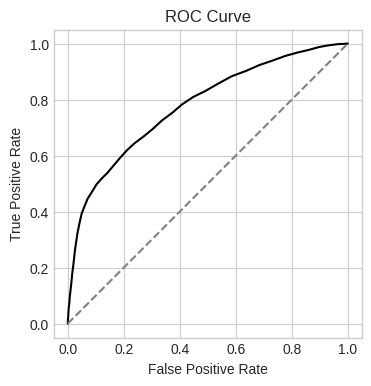

In [26]:
#| fig-cap: "ROC curve for the credit default prediction problem."
#| label: fig-roc-curve

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

num_thresholds = 101

FPR = np.zeros(num_thresholds)
TPR = np.zeros(num_thresholds)
T = np.linspace(s.min()-0.1, s.max()+0.1, num_thresholds)
s    = linear_score(X_train, w)

for i in range(num_thresholds):
    t = T[i]
    preds    = s >= t
    FPR[i]   = ((preds == 1) & (y_train == 0)).sum() / (y_train == 0).sum()
    TPR[i]   = ((preds == 1) & (y_train == 1)).sum() / (y_train == 1).sum()

ax.plot(FPR, TPR, color = "black")
ax.plot([0,1], [0,1], linestyle="--", color = "grey")
ax.set_aspect('equal')

labs = ax.set(xlabel = "False Positive Rate", ylabel = "True Positive Rate", title = "ROC Curve")

We can think of the ROC curve as a description of all the possible tradeoffs between the TPR and FPR that are achievable for a given score as we vary the threshold $t$. For example, the curve tells us that if we are willing to tolerate a false positive rate of 0.40, then the best true positive rate we can achieve is approximately 0.77.

ROC curves are often used as a measure of the ability of a score function to classify data into two groups. Curves that bend farther towards the upper left corner of the plot are generally viewed as more effective classifiers, while curves which follow the dashed line of equality correspond to models that are no better than random chance. The area under the curve (AUC) is sometimes used as a single quantitative measure describing the classification quality.

### Cost of Errors and Optimal Thresholding

How do we choose the tradeoff that works best for us? To answer this kind of question, we need to reflect back on the *purpose* for which we are building a classifier. According to @tbl-errors, there are two ways to be correct (true positive, true negative) and two ways to make an error (false positive, false negative). In order to choose an appropriate tradeoff, we need to think about the *benefit* of being right in relation to the *cost* of being wrong. We can define an *expected benefit from prediction* like this:

$$
\begin{aligned}
    \text{Benefit} =  &\phantom{-}\text{TP}\times (\text{benefit of TP}) + \text{TN} \times (\text{benefit of TN}) \\  
    & \color{white}{-}\text{FP} \times (\text{cost of FP})  - \text{FN}\times(\text{cost of FN})\;.
\end{aligned}
$${#eq-cost-benefit}

To specify our estimated benefit, we must therefore specify the two costs and two benefits using information from our specific decision-making context.

::: {.callout-note}

How would you suggest setting the two cost and two benefit terms in @eq-cost-benefit in the following prediction contexts?

- Shark attack prediction.
- Prediction of whether or not an email is spam.
- Prediction of whether or not a patient has a rare disease.
- Prediction of whether an individual is likely to be arrested for a crime if released on parole.

:::

So far, we have framed the prediction problem of credit default from the bank's perspective -- the bank assesses customers and makes a decision. To continue in this vein, let's consider how a bank might fill out each of the four terms above. In the lending business, a bank can *make* money when loans are fully repaid with interest, but *lose* money (usually much more) when an individual defaults on the loan. On the other hand, when the bank chooses not to make a loan at all (in response to a positive prediction that an individual is likely to default), no credit is extended and there is no gain or loss. So, heuristically, our four terms might look something like this: [In practice, the actual costs and benefits  ]{.aside}

- **Cost of false positives** (individual would have repaid but does not receive loan): 0\$
- **Cost of false negatives** (individual would not have repaid but receives loan): $C$
- **Benefit of true positives** (individual would not have repaid and does not receive loan): 0\$.
- **Benefit of true negatives** (individual would have repaid and indeed receives loan): $c < C$

So, the expected gain for the bank when making a loan is:
$$
\begin{aligned}
    \mathbb{E}[\mathrm{gain}] = c\times \text{TN} - C\times \text{FN}\;.
\end{aligned}
$$

To keep the problem simple, suppose that the bank gains $c = \$1$ every time they make a loan which is successfully paid back, (benefit of true negatives) and that the bank loses $C = \$5$ every time they make a loan which ends in default (cost of false negatives). We can show how this expected gain depends on the threshold $t$ by plotting it as a function of $t$. The structure of this code is very similar to the code we used to generate @fig-accuracy-threshold, but now we are computing the expected gain rather than the accuracy.

In [ ]:
best_benefit = 0
best_threshold = 0

c = 1
C = 5

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
for t in np.linspace(0, 1, 101):
    y_pred = s >= t
    tn = ((y_pred == 0) & (y_train == 0)).mean()
    fn = ((y_pred == 0) & (y_train == 1)).mean()
    benefit = c*tn - C*fn
    ax.scatter(t, benefit, color = "steelblue", s = 10)
    if benefit > best_benefit:
        best_benefit = benefit
        best_threshold = t

ax.axvline(best_threshold, linestyle = "--", color = "grey", zorder = -10)
labs = ax.set(xlabel = r"Threshold $t$", ylabel = "Net benefit", title = f"Best benefit ${best_benefit:.2f} at best threshold t = {best_threshold:.3f}")

For these costs, we observe that the bank can make a small expected profit (roughly 22 cents per loan) by using the given score function with threshold of roughly $t \approx 0.26$. Note that this is very different from the value of the thresold $t \approx 0.42$ which maximized the unweighted accuracy of the predictor.

At this stage, we could go on to estimate the profit gained by using this predictor and threshold on the test data set instead of the training data set. The code below simply consolidates the many steps that we have walked through in these notes, applied to the test data.

In [ ]:
t = 0.26

# compute the scores
s     = linear_score(X_test, w)
preds = s >= t

# compute error rates
FN   = ((preds == 0) & (y_test == 1)).mean()
TN   = ((preds == 0) & (y_test == 0)).mean()
# compute the expected gain
gain = c*TN  - C*FN
gain

Our performance on the test data is very slightly worse than our performance on the training data, which is to be expected.

## Recap

In these notes, we studied a simple question: given a score $s_i = \langle \mathbf{x}_i, \mathbf{w}\rangle$, how should we convert that score into a yes/no decision? We found that adjusting the threshold can have major consequences for the accuracy of the resulting classification algorithm, but also that pure accuracy may not be the most relevant metric to measure or optimize. We computed the ROC curve of the score, which is a visual indicator of the overall ability of the score function to balance the false positive rate against the true positive rate. Finally, we explored the possible tradeoffs between different kinds of errors by considering a simplified scenario in which different kinds of errors have different costs associated with them. We found that the threshold that optimizes expected gain under this setting can be very different from the threshold that optimizes unweighted accuracy.

## Who Sets The Cost? Who Pays the Cost?

In our analysis above, we assumed a simple optimization objective: the bank is going to maximize its net profit. In formulating this objective, we made assumptions about the costs of different outcomes -- **to the bank**. It's important to note that the costs of errors to the bank may look very different from the costs of those errors to individuals. For example, if the bank's prediction system recommends that an individual be denied a loan and the bank acts on this recommendation, then the bank pays no cost. On the other hand, the individual may experience major costs, depending on the purpose for which the loan was requested.

This data set includes a coarse description of the purpose of each loan:

In [ ]:
df_all.groupby("loan_intent").size()

What are the costs of being denied access to borrowed funds to pursue education? What about for medical care?  

It is of fundamental importance to remember that machine learning systems are embedded in social context; that they are generally developed and implemented by people and organizations that occupy positions of power; and that the costs of these systems are often unequally shared by the people they impact. We will discuss these considerations in much greater detail soon.